In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.options.mode.chained_assignment = None

stock_data = pd.read_csv('df2330_12to22.csv')

stock_data['trend'] = np.where(stock_data.Close.shift(-5) > stock_data.Close, 1, 0)
print(stock_data.isnull().sum())

print(stock_data)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
trend     0
dtype: int64
            Date   Open   High    Low  Close     Volume  trend
0     2012-01-02   75.0   75.4   74.7   75.0  14945.219      1
1     2012-01-03   75.5   75.9   75.2   75.7  21223.640      1
2     2012-01-04   76.1   76.1   75.5   75.8  34126.472      1
3     2012-01-05   76.0   76.0   75.3   76.0  28076.670      1
4     2012-01-06   75.9   75.9   74.9   75.6  30123.118      1
...          ...    ...    ...    ...    ...        ...    ...
2697  2022-12-26  454.0  457.0  453.5  456.5   9152.790      0
2698  2022-12-27  458.0  462.5  457.0  457.0  10486.219      0
2699  2022-12-28  451.0  452.0  446.0  451.0  34823.492      0
2700  2022-12-29  444.0  449.5  442.5  446.0  25596.357      0
2701  2022-12-30  455.0  456.5  448.5  448.5  22297.604      0

[2702 rows x 7 columns]


In [2]:
# define the target and features
target = ['Close']
features = ['Volume', 'High', 'Low']

In [3]:
df = stock_data[features + target]
df

,Volume,High,Low,Close
0,14945.219,75.4,74.7,75.0
1,21223.640,75.9,75.2,75.7
2,34126.472,76.1,75.5,75.8
3,28076.670,76.0,75.3,76.0
4,30123.118,75.9,74.9,75.6
...,...,...,...,...
2697,9152.790,457.0,453.5,456.5
2698,10486.219,462.5,457.0,457.0
2699,34823.492,452.0,446.0,451.0
2700,25596.357,449.5,442.5,446.0


In [4]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

In [5]:
# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])


In [6]:
# extract the input sequences and output values
sequence_length = 30

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape)

print(X_test.shape)

(2131, 30, 4)
(511, 30, 4)


In [7]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=32, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
model.save('multi_intput_LSTM_model_eps32_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/32
34/34 [==============================] - 8s 65ms/step - loss: 0.0143
Epoch 2/32
34/34 [==============================] - 2s 66ms/step - loss: 0.0034
Epoch 3/32
34/34 [==============================] - 2s 72ms/step - loss: 0.0029
Epoch 4/32
34/34 [==============================] - 2s 73ms/step - loss: 0.0026
Epoch 5/32
34/34 [==============================] - 2s 65ms/step - loss: 0.0022
Epoch 6/32
34/34 [==============================] - 2s 70ms/step - loss: 0.0026
Epoch 7/32
34/34 [==============================] - 2s 68ms/step - loss: 0.0020
Epoch 8/32
34/34 [==============================] - 2s 67ms/step - loss: 0.0021
Epoch 9/32
34/34 [==============================] - 2s 69ms/step - loss: 0.0019
Epoch 10/32
34/34 [==============================] - 2s 72ms/step - loss: 0.0023
Epoch 11/32
34/34 [==============================] - 2s 72ms/step - loss: 0.0020
Epoch 12/32
34/34 [==============================] - 2s 66ms/step - loss: 0.0022
Epoch 13/32
34/34 [==================

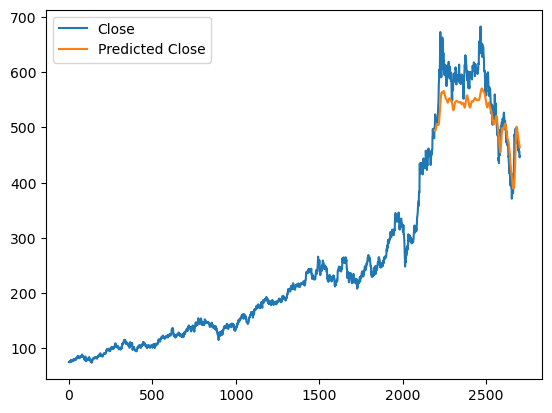

In [8]:
# plot the test set predictions
df['Predicted Close'] = np.nan
df['Predicted Close'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
plot=df[['Close', 'Predicted Close']].plot()
fig = plot.get_figure()
fig.savefig("multi_intput_LSTM_model_eps32_bsize64.png")